In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
class VitInputLayer(nn.Module):
    def __init__(self, in_channels:int=1, emb_dim:int=196, num_patch_row:int=2, image_size:int=32):
        """
        引数：
            in_channels: 入力画像のチャンネル数
            emb_dim: 埋め込み後のベクトルの長さ
            num_patch_row: 高さ方向のパッチ数.とりあえず2
            image_size: 入力画像の1辺の長さ
        """
        super().__init__()
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.num_patch_row = num_patch_row
        self.image_size = image_size
        
        #パッチの数
        #入力が2x2だったら4
        self.num_patch = self.num_patch_row**2
        
        #パッチのサイズ
        #入力画像の1辺が32の時，サイズは16
        self.patch_size = int(self.image_size // self.num_patch_row)
        
        #入力画像のパッチへの分割＆パッチの埋め込みを一気に行う
        self.patch_emb_layer = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.emb_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )
        
        #クラストークン
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, emb_dim)
        )
        
        #位置埋め込み
        #クラストークンを先頭に結合するため
        #パッチ数＋1用意
        self.pos_emb = nn.Parameter(
            torch.randn(1, self.num_patch + 1, emb_dim)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        引数：
            x：入力画像．形状はB,C,H,W
            B：バッチサイズ
        返り値：
            z_0: ViTへの入力．形状はB,N，D
            N；トークン数，D：埋め込みベクトルの長さ
        """
    
        #パッチの埋め込み
        z_0 = self.patch_emb_layer(x)
            
        #flatten(B,D,H/P,W/P) -> (B,D,Np)
        
        z_0 = z_0.flatten(2)
        
        #パッチのflatten(B,D,H/P,W/P) -> (B,D,Np)
        #Npはパッチの数
        z_0 = z_0.transpose(1, 2)
            
        # パッチの埋め込みの先頭にクラストークンを結合 [式(4)] 
        ## (B, Np, D) -> (B, N, D)
        ## N = (Np + 1)であることに留意
        ## また、cls_tokenの形状は(1,1,D)であるため、
        ## repeatメソッドによって(B,1,D)に変換してからパッチの埋め込みとの結合を行う 
        z_0 = torch.cat(
            [self.cls_token.repeat(repeats=(x.size(0),1,1)), z_0], dim=1)

        # 位置埋め込みの加算 [式(5)] 
        ## (B, N, D) -> (B, N, D) 
        #print(z_0.shape, self.pos_emb.shape)
        z_0 = z_0 + self.pos_emb
        return z_0            

In [ ]:
#self, in_channels:int=1, emb_dim:int=196, num_patch_row:int=2, image_size:int=32

#batch_size, channel, height, width = 2,3,32,32
batch_size, channel, height, width = 64,1,28,28
x = torch.randn(batch_size, channel, height, width)
#input_layer = VitInputLayer(in_channels=3, emb_dim=384, num_patch_row=2, image_size=32)
input_layer = VitInputLayer(in_channels=1, emb_dim=196, num_patch_row=2, image_size=28)
z_0 = input_layer(x)
print(z_0.shape)

torch.Size([64, 5, 196])


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_dim:int=196, head:int=4, dropout:float=0.):
        """
        引数：
            emb_dim: 埋め込み後のベクトルの長さ
            head: ヘッドの数
        """
        super().__init__()
        self.head = head
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // head
        self.sqrt_dh = self.head_dim**0.5 #Q・Kを割るための係数
        
        #入力をq,k,vに埋め込むための線形層
        #行列で飛ばしてから区切るから，ここはemb_dimでおk
        self.w_q = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_k = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_v = nn.Linear(emb_dim, emb_dim, bias=False)
         
        self.attn_drop = nn.Dropout(dropout)
        
        #MHSAの結果を出力に埋め込むための線形層
        self.w_o = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, z:torch.Tensor) -> torch.Tensor:
        """
        引数：
            z:MHSAへの入力．（B,N,D）
        返り値：
            out:MHSAの出力．(B,N,D)
        """
        batch_size, num_patch, _ = z.size()
        
        #embed
        q = self.w_q(z)
        k = self.w_k(z)
        v = self.w_v(z)
        
        #print(self.head_dim, self.emb_dim, self.head)
        q = q.view(batch_size, num_patch, self.head, self.head_dim)
        k = k.view(batch_size, num_patch, self.head, self.head_dim)
        v = v.view(batch_size, num_patch, self.head, self.head_dim)
        
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        
            # 内積 [式(7)]
        ## (B, h, N, D//h) -> (B, h, D//h, N)
        k_T = k.transpose(2, 3)
        ## (B, h, N, D//h) x (B, h, D//h, N) -> (B, h, N, N) 
        dots = (q @ k_T) / self.sqrt_dh
        ## 列方向にソフトマックス関数
        attn = F.softmax(dots, dim=-1)
        ## ドロップアウト
        attn = self.attn_drop(attn)
        # 加重和 [式(8)]
        ## (B, h, N, N) x (B, h, N, D//h) -> (B, h, N, D//h) 
        out = attn @ v
        ## (B, h, N, D//h) -> (B, N, h, D//h)
        out = out.transpose(1, 2)
        ## (B, N, h, D//h) -> (B, N, D)
        out = out.reshape(batch_size, num_patch, self.emb_dim)

        # 出力層 [式(10)]
        ## (B, N, D) -> (B, N, D) 
        out = self.w_o(out) 
        return out

In [ ]:
mhsa = MultiHeadSelfAttention()
out = mhsa(z_0)
out.shape

torch.Size([64, 5, 196])

In [ ]:
class VitEncoderBlock(nn.Module): 
    def __init__(self, emb_dim:int=196, head:int=7, hidden_dim:int=196*4, dropout: float=0.):
        """
        引数:
            emb_dim: 埋め込み後のベクトルの長さ
            head: ヘッドの数
            hidden_dim: Encoder BlockのMLPにおける中間層のベクトルの長さ 
                        原論文に従ってemb_dimの4倍をデフォルト値としている
            dropout: ドロップアウト率
        """
        super().__init__()
        # 1つ目のLayer Normalization [2-5-2項]
        self.ln1 = nn.LayerNorm(emb_dim)
        # MHSA [2-4-7項]
        self.msa = MultiHeadSelfAttention(
        emb_dim=emb_dim, head=head,
        dropout = dropout,
        )
        # 2つ目のLayer Normalization [2-5-2項] 
        self.ln2 = nn.LayerNorm(emb_dim)
        # MLP [2-5-3項]
        self.mlp = nn.Sequential( 
            nn.Linear(emb_dim, hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, emb_dim), 
            nn.Dropout(dropout)
        )
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """ 
        引数:
            z: Encoder Blockへの入力。形状は、(B, N, D)
                B: バッチサイズ、N:トークンの数、D:ベクトルの長さ

        返り値:
            out: Encoder Blockへの出力。形状は、(B, N, D)。[式(10)]
                B:バッチサイズ、N:トークンの数、D:埋め込みベクトルの長さ 
        """
        # Encoder Blockの前半部分 [式(12)] 
        out = self.msa(self.ln1(z)) + z
        # Encoder Blockの後半部分 [式(13)] 
        out = self.mlp(self.ln2(out)) + out 
        return out

In [ ]:
vit_enc = VitEncoderBlock()
z_1 = vit_enc(z_0)
z_1.shape

torch.Size([64, 5, 196])

In [ ]:
class Vit(nn.Module): 
    def __init__(self, in_channels:int=1, num_classes:int=10, emb_dim:int=196, num_patch_row:int=2, image_size:int=28, num_blocks:int=7, head:int=7, hidden_dim:int=196*4, dropout:float=0.):
        """ 
        引数:
            in_channels: 入力画像のチャンネル数
            num_classes: 画像分類のクラス数
            emb_dim: 埋め込み後のベクトルの長さ
            num_patch_row: 1辺のパッチの数
            image_size: 入力画像の1辺の大きさ。入力画像の高さと幅は同じであると仮定 
            num_blocks: Encoder Blockの数
            head: ヘッドの数
            hidden_dim: Encoder BlockのMLPにおける中間層のベクトルの長さ 
            dropout: ドロップアウト率
        """
        super(Vit, self).__init__()
        # Input Layer [2-3節] 
        self.input_layer = VitInputLayer(
            in_channels, 
            emb_dim, 
            num_patch_row, 
            image_size)

        # Encoder。Encoder Blockの多段。[2-5節] 
        self.encoder = nn.Sequential(*[
            VitEncoderBlock(
                emb_dim=emb_dim,
                head=head,
                hidden_dim=hidden_dim,
                dropout = dropout
            )
            for _ in range(num_blocks)])

        # MLP Head [2-6-1項] 
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        引数:
            x: ViTへの入力画像。形状は、(B, C, H, W)
                B: バッチサイズ、C:チャンネル数、H:高さ、W:幅

        返り値:
            out: ViTの出力。形状は、(B, M)。[式(10)]
                B:バッチサイズ、M:クラス数 
        """
        # Input Layer [式(14)]
        ## (B, C, H, W) -> (B, N, D)
        ## N: トークン数(=パッチの数+1), D: ベクトルの長さ 
        out = self.input_layer(x)
        
        # Encoder [式(15)、式(16)]
        ## (B, N, D) -> (B, N, D)
        out = self.encoder(out)

        # クラストークンのみ抜き出す
        ## (B, N, D) -> (B, D)
        cls_token = out[:,0]

        # MLP Head [式(17)]
        ## (B, D) -> (B, M)
        pred = self.mlp_head(cls_token)
        return pred

In [ ]:
num_classes = 10
batch_size, channel, height, width= 64, 1, 28, 28
x = torch.randn(batch_size, channel, height, width)
input_layer = VitInputLayer(in_channels=1, emb_dim=196, num_patch_row=2, image_size=28)

vit = Vit(in_channels=channel, num_classes=num_classes) 
pred = vit(x)
print(x.shape)
print(pred.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


# Fashion MNISTで実験

In [ ]:
tr = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
te = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



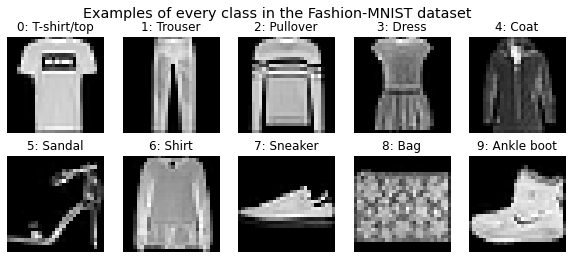

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class_ids, sample_indices = np.unique(tr.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle(
    "Examples of every class in the Fashion-MNIST dataset", fontsize="x-large"
)

for i in class_ids:
    img = tr.data[sample_indices[i]]
    class_name = tr.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

In [ ]:
batch_size = 64

train_dataloader = DataLoader(tr, batch_size=batch_size)
test_dataloader = DataLoader(te, batch_size=batch_size)

for X,y in test_dataloader:
    print(f'Shape of X [N,C,H,W]: {X.shape}')
    print(f'Shape of y: {y.shape}{y.dtype}')
    break

Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])torch.int64


In [ ]:
channel = 1
num_classes = 10

model = Vit(in_channels=channel, num_classes=num_classes).to(device)
#model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optim):
    size = len(dataloader.dataset)
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss :{loss:>7f} [{current:>5d}/{size:>5d}]')

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct) :>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [ ]:
epochs = 20
for t in range(epochs):
    print(f'Epoch {t+1}\n ------------------------------')
    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
print('done!!')

Epoch 1
 ------------------------------
loss :2.304725 [    0/60000]
loss :2.294056 [ 6400/60000]
loss :2.268944 [12800/60000]
loss :2.276838 [19200/60000]
loss :2.243063 [25600/60000]
loss :2.236425 [32000/60000]
loss :2.218407 [38400/60000]
loss :2.180838 [44800/60000]
loss :2.165152 [51200/60000]
loss :2.143789 [57600/60000]
Test Error: 
 Accuracy: 32.7%, Avg loss: 2.087448 

Epoch 2
 ------------------------------
loss :2.095636 [    0/60000]
loss :2.112834 [ 6400/60000]
loss :1.901615 [12800/60000]
loss :1.933362 [19200/60000]
loss :1.635108 [25600/60000]
loss :1.515678 [32000/60000]
loss :1.319115 [38400/60000]
loss :1.005918 [44800/60000]
loss :1.035016 [51200/60000]
loss :0.971825 [57600/60000]
Test Error: 
 Accuracy: 66.0%, Avg loss: 0.930729 

Epoch 3
 ------------------------------
loss :0.901092 [    0/60000]
loss :0.930700 [ 6400/60000]
loss :0.620948 [12800/60000]
loss :0.859427 [19200/60000]
loss :0.762310 [25600/60000]
loss :0.766150 [32000/60000]
loss :0.703605 [38400/